In [18]:
import numpy as np
import time
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap

class my_gridworld_2():
    
    def __init__(self,**args):
                
        ### initialize global containers and variables
        # initialize containers for grid, hazard locations, agent and goal locations, etc.,
        self.grid = []
        self.hazards = []
        self.agent = []
        self.goal = []
        
        # initialize global variables e.g., height and width of gridworld, hazard penalty value
        self.width = 0
        self.height = 0
        self.hazard_penalty = 0
        
        ### check for optional arguments controlling size of gridworld, number/placement/value of hazards.  If no args given go to default.
        # check if a pre-defined gridworld is desired
        if "world" in args:
            # small demo gridworld
            if args['world'] == 'small demo':
                ### initialize grid, agent, obstacles, etc.,
                self.width = 5
                self.height = 4
                self.grid = np.zeros((self.height,self.width))

                # initialize goal location
                self.goal = [0,self.width-1]     # goal block
                self.grid[self.goal[0]][self.goal[1]] = 2
                
                # initialize player location
                self.player = [0,0]   # initial location player
                self.grid[self.player[0]][self.player[1]] = 3                
                
                # initialize hazard locations
                self.hazards = [[0,3],[1,3],[2,3]]  # impenetrable obstacle locations          
                for i in range(len(self.hazards)): 
                    block = self.hazards[i]
                    self.hazards.append(block)
                    self.grid[block[0]][block[1]] = 1
                                                  
            # small random gridworld
            if args['world'] == 'small random':
                ### initialize locations ###
                # initialize grid, agent, hazards, etc.,
                self.width = 7
                self.height = 7
                self.grid = np.zeros((self.height,self.width))
                            
                # initialize goal location
                self.goal = [0,self.width-1]     # goal block
                self.grid[self.goal[0]][self.goal[1]] = 2
                
                # initialize player location
                self.player = [0,0]   # initial location player
                self.grid[self.player[0]][self.player[1]] = 3   
                
                # initialize random hazards locations
                num_hazards = 15
                self.hazards = []
                inds = np.random.permutation(self.width*self.height)
                inds = inds[:num_hazards]
                k = 0
                for i in range(self.height):
                    for j in range(self.width):
                        if k in inds: 
                            block = [i,j]
                            if block != self.goal and block != self.player:
                                self.hazards.append(block)
                                self.grid[block[0]][block[1]] = 1
                        k+=1
            
            # initialize a big gridworld with randomly placed hazards.  
            if args["world"] == 'big random':
                ### initialize locations ###
                # initialize grid, agent, hazards, etc.,
                self.width = 20
                self.height = 10
                self.grid = np.zeros((self.height,self.width))

                # initialize goal location
                self.goal = [0,self.width-1]     # goal block
                self.grid[self.goal[0]][self.goal[1]] = 2
                
                # initialize player location
                self.player = [0,0]   # initial location player
                self.grid[self.player[0]][self.player[1]] = 3   
                
                # initialize random hazards locations
                num_hazards = 50
                self.hazards = []
                inds = np.random.permutation(self.width*self.height)
                inds = inds[:num_hazards]
                k = 0
                for i in range(self.height):
                    for j in range(self.width):
                        if k in inds: 
                            block = [i,j]
                            if block != self.goal and block != self.player:
                                self.hazards.append(block)
                                self.grid[block[0]][block[1]] = 1
                        k+=1
        
            # small maze gridworld                      
            if args["world"] == 'small maze':
                # load in preset hazard locations from csv
                hazards = np.asarray(pd.read_csv('RL_datasets/small_maze.csv',header = None))
                
                ### initialize grid, agent, obstacles, etc.,            
                self.width = 13
                self.height = 11
                self.grid = np.zeros((self.height,self.width))
                
                # initialize goal location
                self.goal = [self.height-2, self.width-1]     # goal block
                self.grid[self.goal[0]][self.goal[1]] = 2
                
                # initialize player location
                self.player = [self.height-2, 0]   # initial location player
                self.grid[self.player[0]][self.player[1]] = 3   
  
                # initialize hazards locations
                for block in hazards: 
                    self.hazards.append(block)
                    self.grid[block[0]][block[1]] = 1
        
            # big maze gridworld                      
            if args["world"] == 'big maze':
                # load in preset hazard locations from csv
                hazards = np.asarray(pd.read_csv('RL_datasets/big_maze.csv',header = None))
                
                ### initialize grid, agent, obstacles, etc.,            
                self.width = 41
                self.height = 15
                self.grid = np.zeros((self.height,self.width))

                # initialize goal location
                self.goal = [self.height-2, self.width-1]     # goal block
                self.grid[self.goal[0]][self.goal[1]] = 2

                # initialize player location
                self.player = [self.height-2, 0]   # initial location player
                self.grid[self.player[0]][self.player[1]] = 3   

                # initialize player location
                self.player = [0,0]   # initial location player
                self.grid[self.player[0]][self.player[1]] = 3   
                
                # initialize hazards locations
                for block in hazards: 
                    self.hazards.append(block)
                    self.grid[block[0]][block[1]] = 1
                    
        ### check for hazard penalty value ###
        if "hazard value" in args:
            self.hazard_penalty = args['hazard value']
        else:
            self.hazard_penalty = max(self.width,self.height)        
        
        ### initialize state index, Q matrix, and action choices ###
        # index states for Q matrix
        self.states = []
        for i in range(self.height):
            for j in range(self.width):
                block = [i,j]
                self.states.append(str(i) + str(j))
        
        # initialize action choices
        self.action_choices = [[-1,0],[1,0],[0,-1],[0,1]]
        
        # initialize Q^* matrix
        self.Q_star = np.zeros((self.width*self.height,len(self.action_choices)))

        ### create custom colormap for gridworld plotting ###
        vmax = 3.0
        self.my_cmap = LinearSegmentedColormap.from_list('mycmap', [(0 / vmax, [0.9,0.9,0.9]),
                                                        (1 / vmax, [1,0.5,0]),
                                                        (2 / vmax, 'lime'),
                                                        (3 / vmax, 'blue')]
                                                        )
        
    ### world coloring function ###
    def color_gridworld(self,ax):
        # plot gridworld
        ax.pcolormesh(self.grid,edgecolors = 'k',linewidth = 0.01,cmap = self.my_cmap)

        # clean up plot
        ax.axis('off')
        ax.set_xlim(-0.1,self.width + 1.1);
        ax.set_ylim(-0.1,self.height + 1.1);        
        
    ## Q-learning function
    def qlearn(self,num_train_animate):
        # parameters for the qlearning 
        gamma = 0.8
        num_episodes = 300
        num_complete = 0
        
        # loop over episodes, for each run simulation and update Q
        for n in range(num_episodes):
            # pick initialization 
            obstical_free = 0
            loc = [np.random.randint(self.grid.height),np.random.randint(self.grid.width)]
           
            # update Q matrix while loc != goal
            steps = 0  # step counter
            max_steps = 10*self.grid.width*self.grid.height  # maximum number of steps per episode
            while steps < max_steps:    
                # when you reach the goal end current episode
                if loc == self.goal:
                    break
                    
                ### choose action - left = 0, right = 1, up = 2, down = 3
                k = np.random.randint(len(self.action_choices))  
                loc2 = [sum(x) for x in zip(loc, self.action_choices[k])] 
                ind_old = self.states.index(str(loc[0]) + str(loc[1]))

                ### set reward    
                # is the new location just a regular square?  Than small negative reward
                r_k = int(-1)

                # if new state is hazard penalize with medium negative value - this needs to be set properly if you're trying to prove a point i.e., that a trained agent won't walk over one of these unless going around costs more
                if loc2 in self.hazards:
                    r_k = self.hazard_penalty

                # if new state is goal set reward of 0
                if loc2 == self.goal:
                    r_k = int(0)
                    
                # if new state is outside of boundaries of grid world penalize set reward to small negative value (like -1) and do not move
                if loc2[0] > self.grid.height-1 or loc2[0] < 0 or loc2[1] > self.grid.width-1 or loc2[1] < 0:  
                    r_k = int(-1)
                    loc2 = loc
                
                ### Update Q
                ind_new = self.states.index(str(loc2[0]) + str(loc2[1]))
                self.Q_star[ind_old,k] = r_k + gamma*max(self.Q_star[ind_new,:])
                    
                # update current location of player to one we just moved too (or stay still if grid world boundary met)
                self.player = loc2
                loc = loc2
                
                # the next few lines just animate the first few steps during the first few episodes
                if n < num_train_animate and steps < 200:
                    self.color_grid()
                    time.sleep(0.1)
                    display.clear_output(wait=True)
                    
                # update counter
                steps+=1
        
            # pause briefly between first few episodes to show user cutoff
            if n < num_train_animate:
                time.sleep(1)
                print 'finished episode, animating next episode'
                time.sleep(1)
            if n == num_train_animate:
                print 'continuing with remaining episodes without animation...'
                
        print 'q-learning process complete'
                
    # print out
    def show_qmat(self):        
        states_print = []
        for i in range(len(self.states)):
            s = str(self.states[i])
            t = str('(') + s[0] + ',' + s[1] + str(')')
            states_print.append(t)
            
        df = pd.DataFrame(self.Q_star,columns=['up','down','left','right'], index=states_print)
        print df.round(3)             
            
    # animate the testing phase based on completed Q-learning cycle
    def animate_testing_phase(self,loc):
        # show movement based on an initial 
        self.player = loc # initial agent location

        # if you chose an invalid starting position, break out and try again
        if  loc == self.goal or loc[0] > self.grid.height-1 or loc[0] < 0 or loc[1] > self.grid.width-1 or loc[1] < 0:
            print 'initialization is outside of gridworld or is goal, try again'
        else:  
            # now use the learned Q* matrix to run from any (valid) initial point to the goal
            self.color_grid()
            time.sleep(0.3)
            display.clear_output(wait=True)
            count = 0
            max_count = self.grid.width*self.grid.height
            while count < max_count:
                # find next state using max Q* value
                ind_old = self.states.index(str(self.player[0]) + str(self.player[1]))
                
                # find biggest value in Q* and determine block location
                action_ind = np.argmax(self.Q_star[ind_old,:])
                action = self.action_choices[action_ind]
                
                # move player to new location and recolor - if you move out of gridworld halt and report this to user
                new_loc = [sum(x) for x in zip(self.player,action)] 
                
                if new_loc[0] > self.grid.height-1 or new_loc[0] < 0 or new_loc[1] > self.grid.width-1 or new_loc[1] < 0:
                    print 'something went wrong - the player has left the gridworld arena'
                    print "your episodes did not the states reached by your initialization enough to train Q properly here"
                    print "this is likely because you didn't traiin long enough - up the number of steps / episodes and try again"
                    
                self.player = new_loc
                
                # clear current screen for next step
                self.color_grid()
                time.sleep(0.2)
                if self.player == self.goal:
                    break
                display.clear_output(wait=True)
                count+=1

In [25]:
test = my_gridworld_2(world = 'big maze')

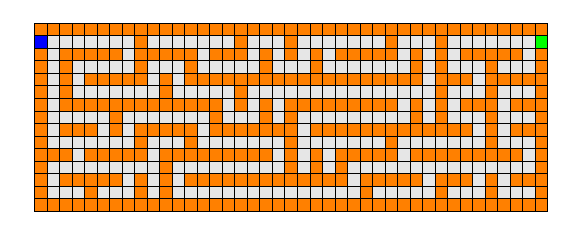

In [27]:
fig1 = plt.figure(figsize = (15,15))
ax1 = fig1.add_subplot(121, aspect='equal')
test.color_gridworld(ax1)
plt.show()

In [82]:
test.grid[0]

array([ 3.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.])

In [4]:
test.grid

[]

In [ ]:
# train q learning and lets examine the matrix as it develops
test.qlearn(num_train_animate = 1)

In [64]:
# run testing phase
starting_location = [1,0]
test.animate_testing_phase(starting_location)

,,,,
,,,,
,,,,
,,,,
